In [1]:
import os
import sys
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib.patches as mpatches
sys.path.append("/projects/b1198/epifluidlab/ravi/0130/headneck/scripts")
from loaders import HNSCCFeatureHandler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import balanced_accuracy_score, roc_curve, auc, roc_auc_score, confusion_matrix


METADATA_PATH = "/projects/b1198/epifluidlab/ravi/0130/headneck/metadata/RAW_HNSCC_METADATA.csv"
VALID_IDS_PATH = "/projects/b1198/epifluidlab/ravi/0130/headneck/notebooks/lists/valid_ids.txt"

# Loading the coverage feature. (cov)
cov = HNSCCFeatureHandler(METADATA_PATH, VALID_IDS_PATH)
_ = cov.load_feature_to_dataframe("/projects/b1198/epifluidlab/ravi/0130/headneck/data/hg38_frag_filtered/*.hg38.frag.delfi.bed", 1, 11)
_ = cov.normalize_total_sum()
_ = cov.normalize_zscore()
_ = cov.merge_feature_metadata()
_ = cov.batch_correct()

# Loading the DELFI feature. (delfi)
delfi = HNSCCFeatureHandler(METADATA_PATH, VALID_IDS_PATH)
_ = delfi.load_feature_to_dataframe("/projects/b1198/epifluidlab/ravi/0130/headneck/data/hg38_frag_filtered/*.hg38.frag.delfi.bed", 1, 12)
_ = delfi.normalize_zscore()
_ = delfi.merge_feature_metadata()
_ = delfi.batch_correct()

# Loading the MDS feature. (mds)
mds = HNSCCFeatureHandler(METADATA_PATH, VALID_IDS_PATH)
_ = mds.load_feature_to_dataframe("/projects/b1198/epifluidlab/ravi/0130/headneck/data/hg38_frag_filtered/*.hg38.frag.interval_mds.tsv", 0, 4)
_ = mds.normalize_zscore()
_ = mds.merge_feature_metadata()
_ = mds.batch_correct()

# Loading the fragment length feature. (fraglen)
fraglen = HNSCCFeatureHandler(METADATA_PATH, VALID_IDS_PATH)
_ = fraglen.load_feature_to_dataframe("/projects/b1198/epifluidlab/ravi/0130/headneck/data/hg38_frag_filtered/*.hg38.frag.frag_length_intervals.bed", 1, 4)
_ = fraglen.normalize_zscore()
_ = fraglen.merge_feature_metadata()
_ = fraglen.batch_correct()

# Loading the ichorCNA feature. (cna)
cna = HNSCCFeatureHandler(METADATA_PATH, VALID_IDS_PATH)
_ = cna.load_feature_to_dataframe("/projects/b1198/epifluidlab/ravi/0130/headneck/data/ichorCNA/expanded/*.cna.seg", 1, 5, na_value="NA")
_ = cna.normalize_zscore()
_ = cna.merge_feature_metadata()
_ = cna.batch_correct()

# Function to get the training and testing data.
def prepare_train_test(hc_data):
    train_ids = list(hc_data.institute1_ids) + list(hc_data.institute2_ids) + list(hc_data.institute3_ids) + list(hc_data.institute4_ids)
    test_ids = list(hc_data.institute5_ids) + list(hc_data.institute6_ids)

    # Training data
    final_patient_df_train = hc_data.get_raw_features(hc_data.get_subset(train_ids))
    final_patient_df_train_metadata = hc_data.get_metadata_col("Treatment Response", hc_data.get_subset(train_ids))
    final_patient_df_train = pd.concat([final_patient_df_train, final_patient_df_train_metadata], axis=1)

    # Test data
    final_patient_df_test = hc_data.get_raw_features(hc_data.get_subset(test_ids))
    final_patient_df_test_metadata = hc_data.get_metadata_col("Treatment Response", hc_data.get_subset(test_ids))
    final_patient_df_test = pd.concat([final_patient_df_test, final_patient_df_test_metadata], axis=1)

    return final_patient_df_train, final_patient_df_test.astype(str)

cov_train, cov_test = prepare_train_test(cov)
delfi_train, delfi_test = prepare_train_test(delfi)
mds_train, mds_test = prepare_train_test(mds)
fraglen_train, fraglen_test = prepare_train_test(fraglen)
cna_train, cna_test = prepare_train_test(cna)

# Models
models = [
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier()
]

# Hyperparameter grids
param_grids = {
    'RandomForestClassifier': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    },
    'GradientBoostingClassifier': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'AdaBoostClassifier': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0]
    }
}


                      Institute  Library_Prep_Date  cfDNA_Isolation_Date  \
Institute              1.000000          -0.465808              0.542575   
Library_Prep_Date     -0.465808           1.000000             -0.673446   
cfDNA_Isolation_Date   0.542575          -0.673446              1.000000   
Treatment_Response    -0.131130          -0.031933              0.290295   

                      Treatment_Response  
Institute                      -0.131130  
Library_Prep_Date              -0.031933  
cfDNA_Isolation_Date            0.290295  
Treatment_Response              1.000000  
                      Institute  Library_Prep_Date  cfDNA_Isolation_Date  \
Institute              1.000000          -0.465808              0.542575   
Library_Prep_Date     -0.465808           1.000000             -0.673446   
cfDNA_Isolation_Date   0.542575          -0.673446              1.000000   
Treatment_Response    -0.131130          -0.031933              0.290295   

                      T

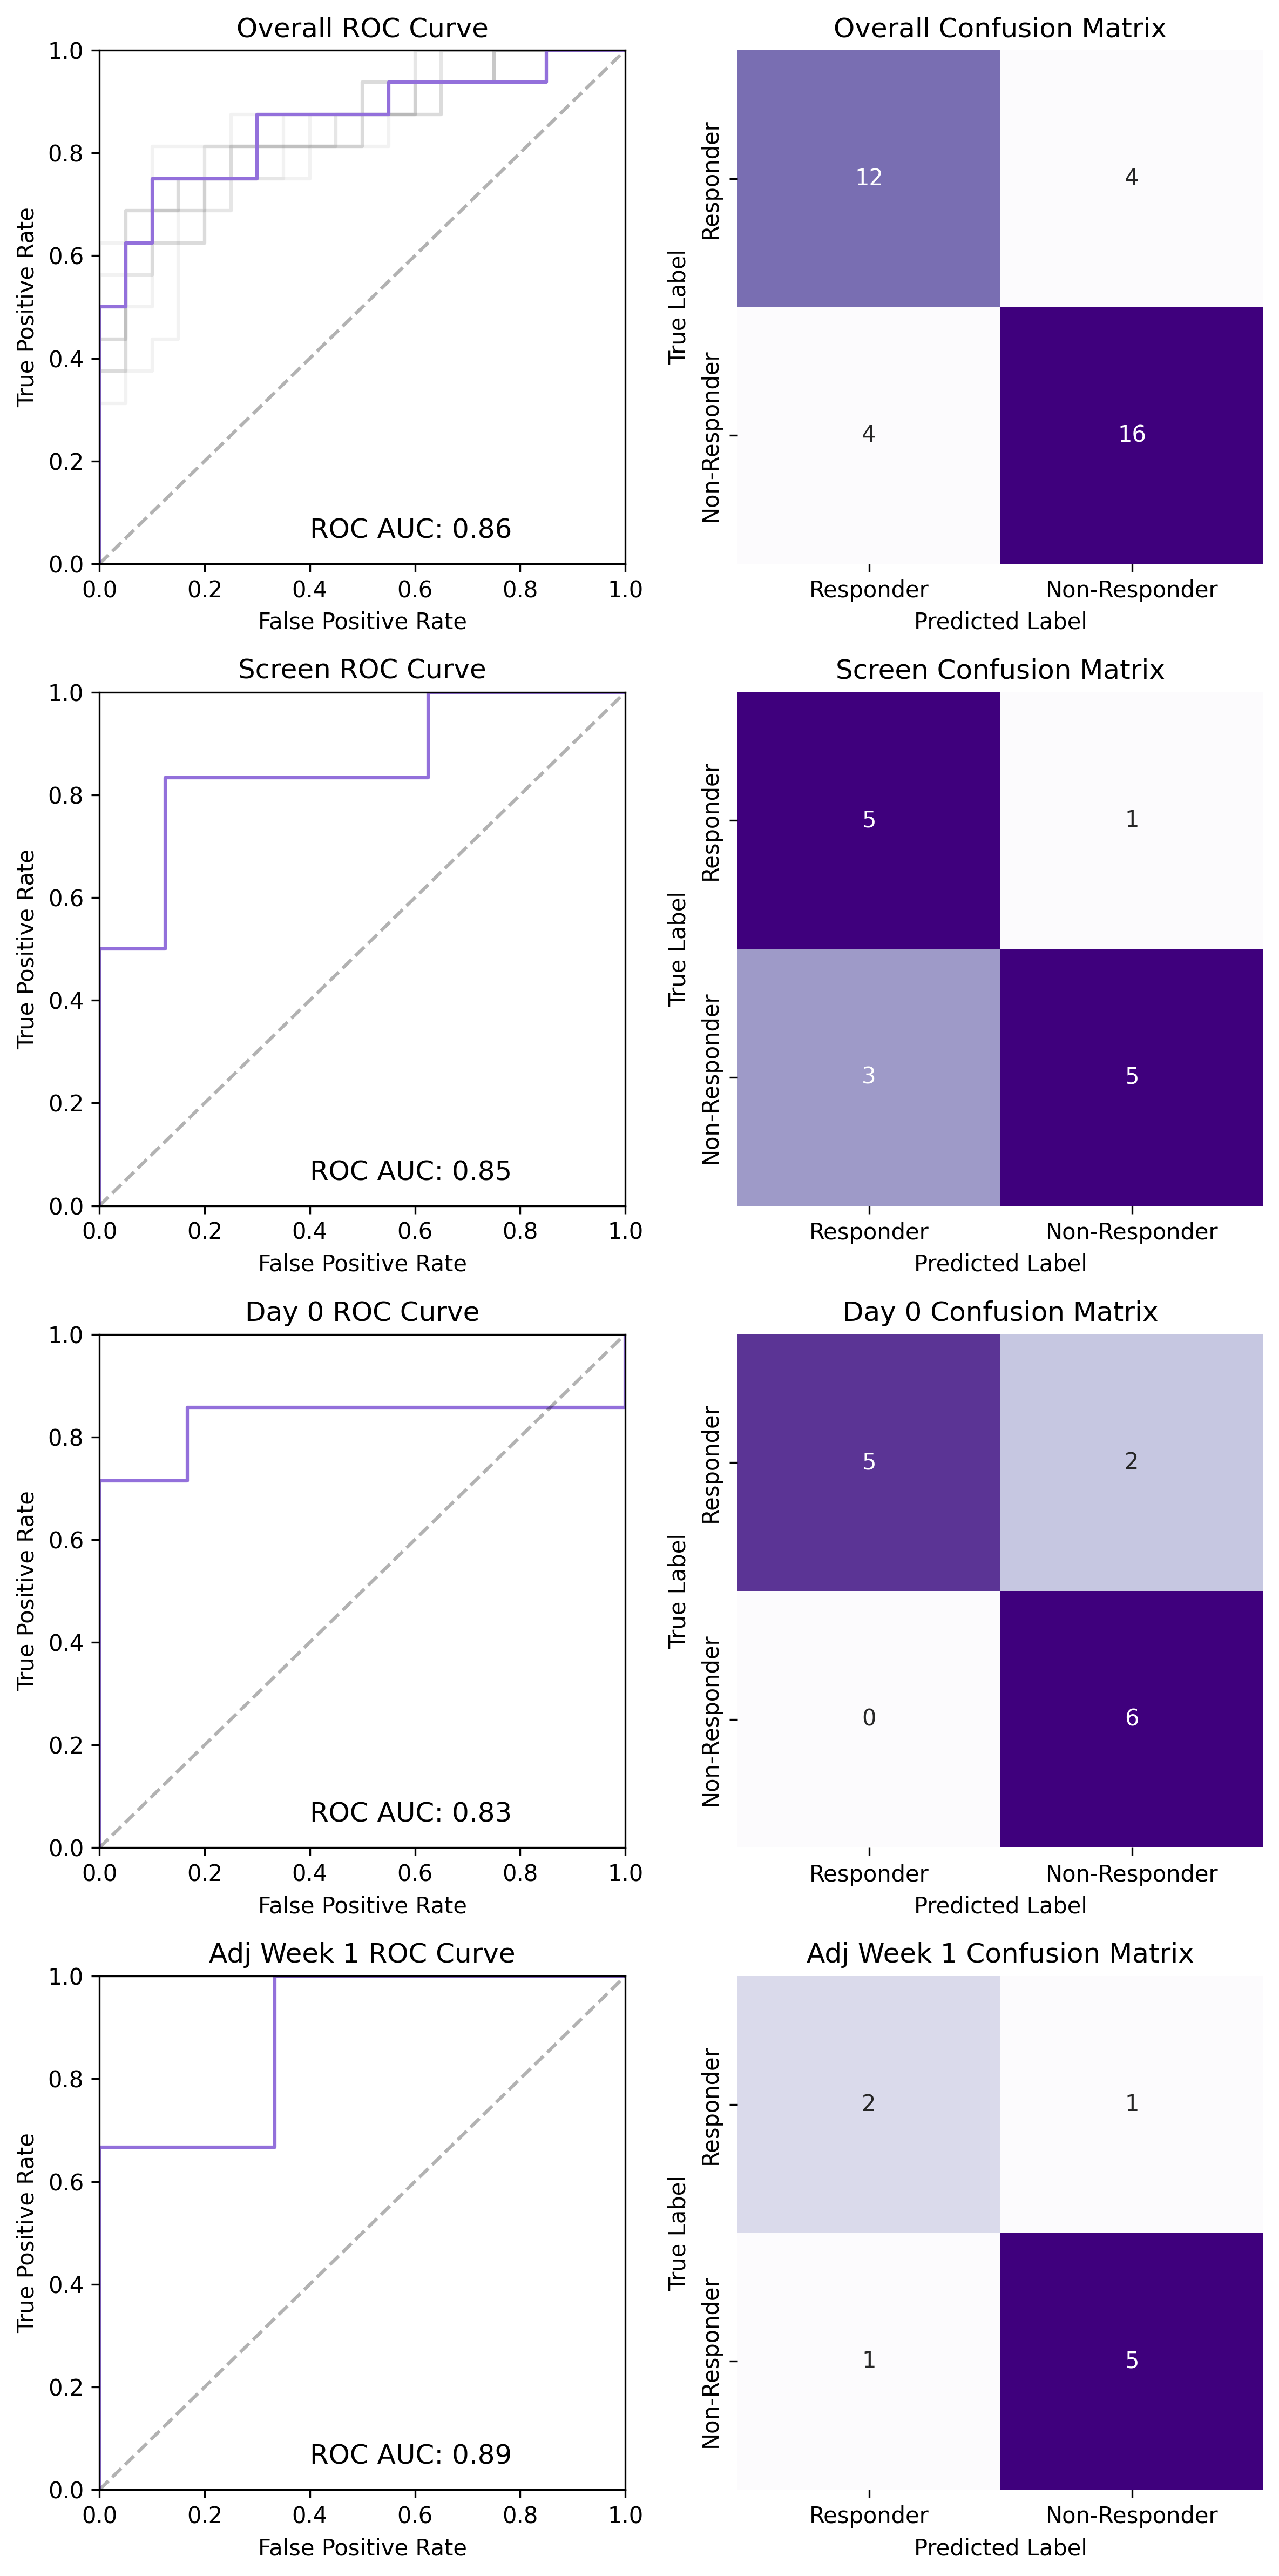

Best Overall Model: RandomForestClassifier(max_features='log2', min_samples_split=5)
Top Features: ['chr10:72500000-73000000', 'chr11:102500000-103000000', 'chr11:103000000-103500000', 'chr12:118500000-119000000', 'chr12:88500000-89000000', 'chr16:10000000-10500000', 'chr16:52000000-52500000', 'chr16:59500000-60000000', 'chr16:61500000-62000000', 'chr1:27000000-27500000', 'chr20:42500000-43000000', 'chr22:28000000-28500000', 'chr4:141500000-142000000', 'chr4:174000000-174500000', 'chr5:35000000-35500000', 'chr5:5000000-5500000', 'chr5:5500000-6000000', 'chr7:79000000-79500000', 'chr17:13500000-14000000', 'chr5:100500000-101000000', 'chr5:157000000-157500000', 'chr12:64000000-64500000', 'chr10:58500000-59000000', 'chr1:236000000-236500000', 'chr2:14500000-15000000', 'chr5:52500000-53000000', 'chr5:7000000-7500000', 'chr14:78000000-78500000', 'chr16:7500000-8000000', 'chr4:155000000-155500000', 'chr6:25500000-26000000', 'chr6:28000000-28500000', 'chr17:17000000-17500000', 'chr2:19500000-

In [2]:
cov_rfc_results, cov_rfc_model, cov_rfc_top_features, cov_rfc_preds_dictionary, cov_data = cov.train_test_model(models[0], param_grids['RandomForestClassifier'], cov_train, cov_test, cv_split=10, k=50)

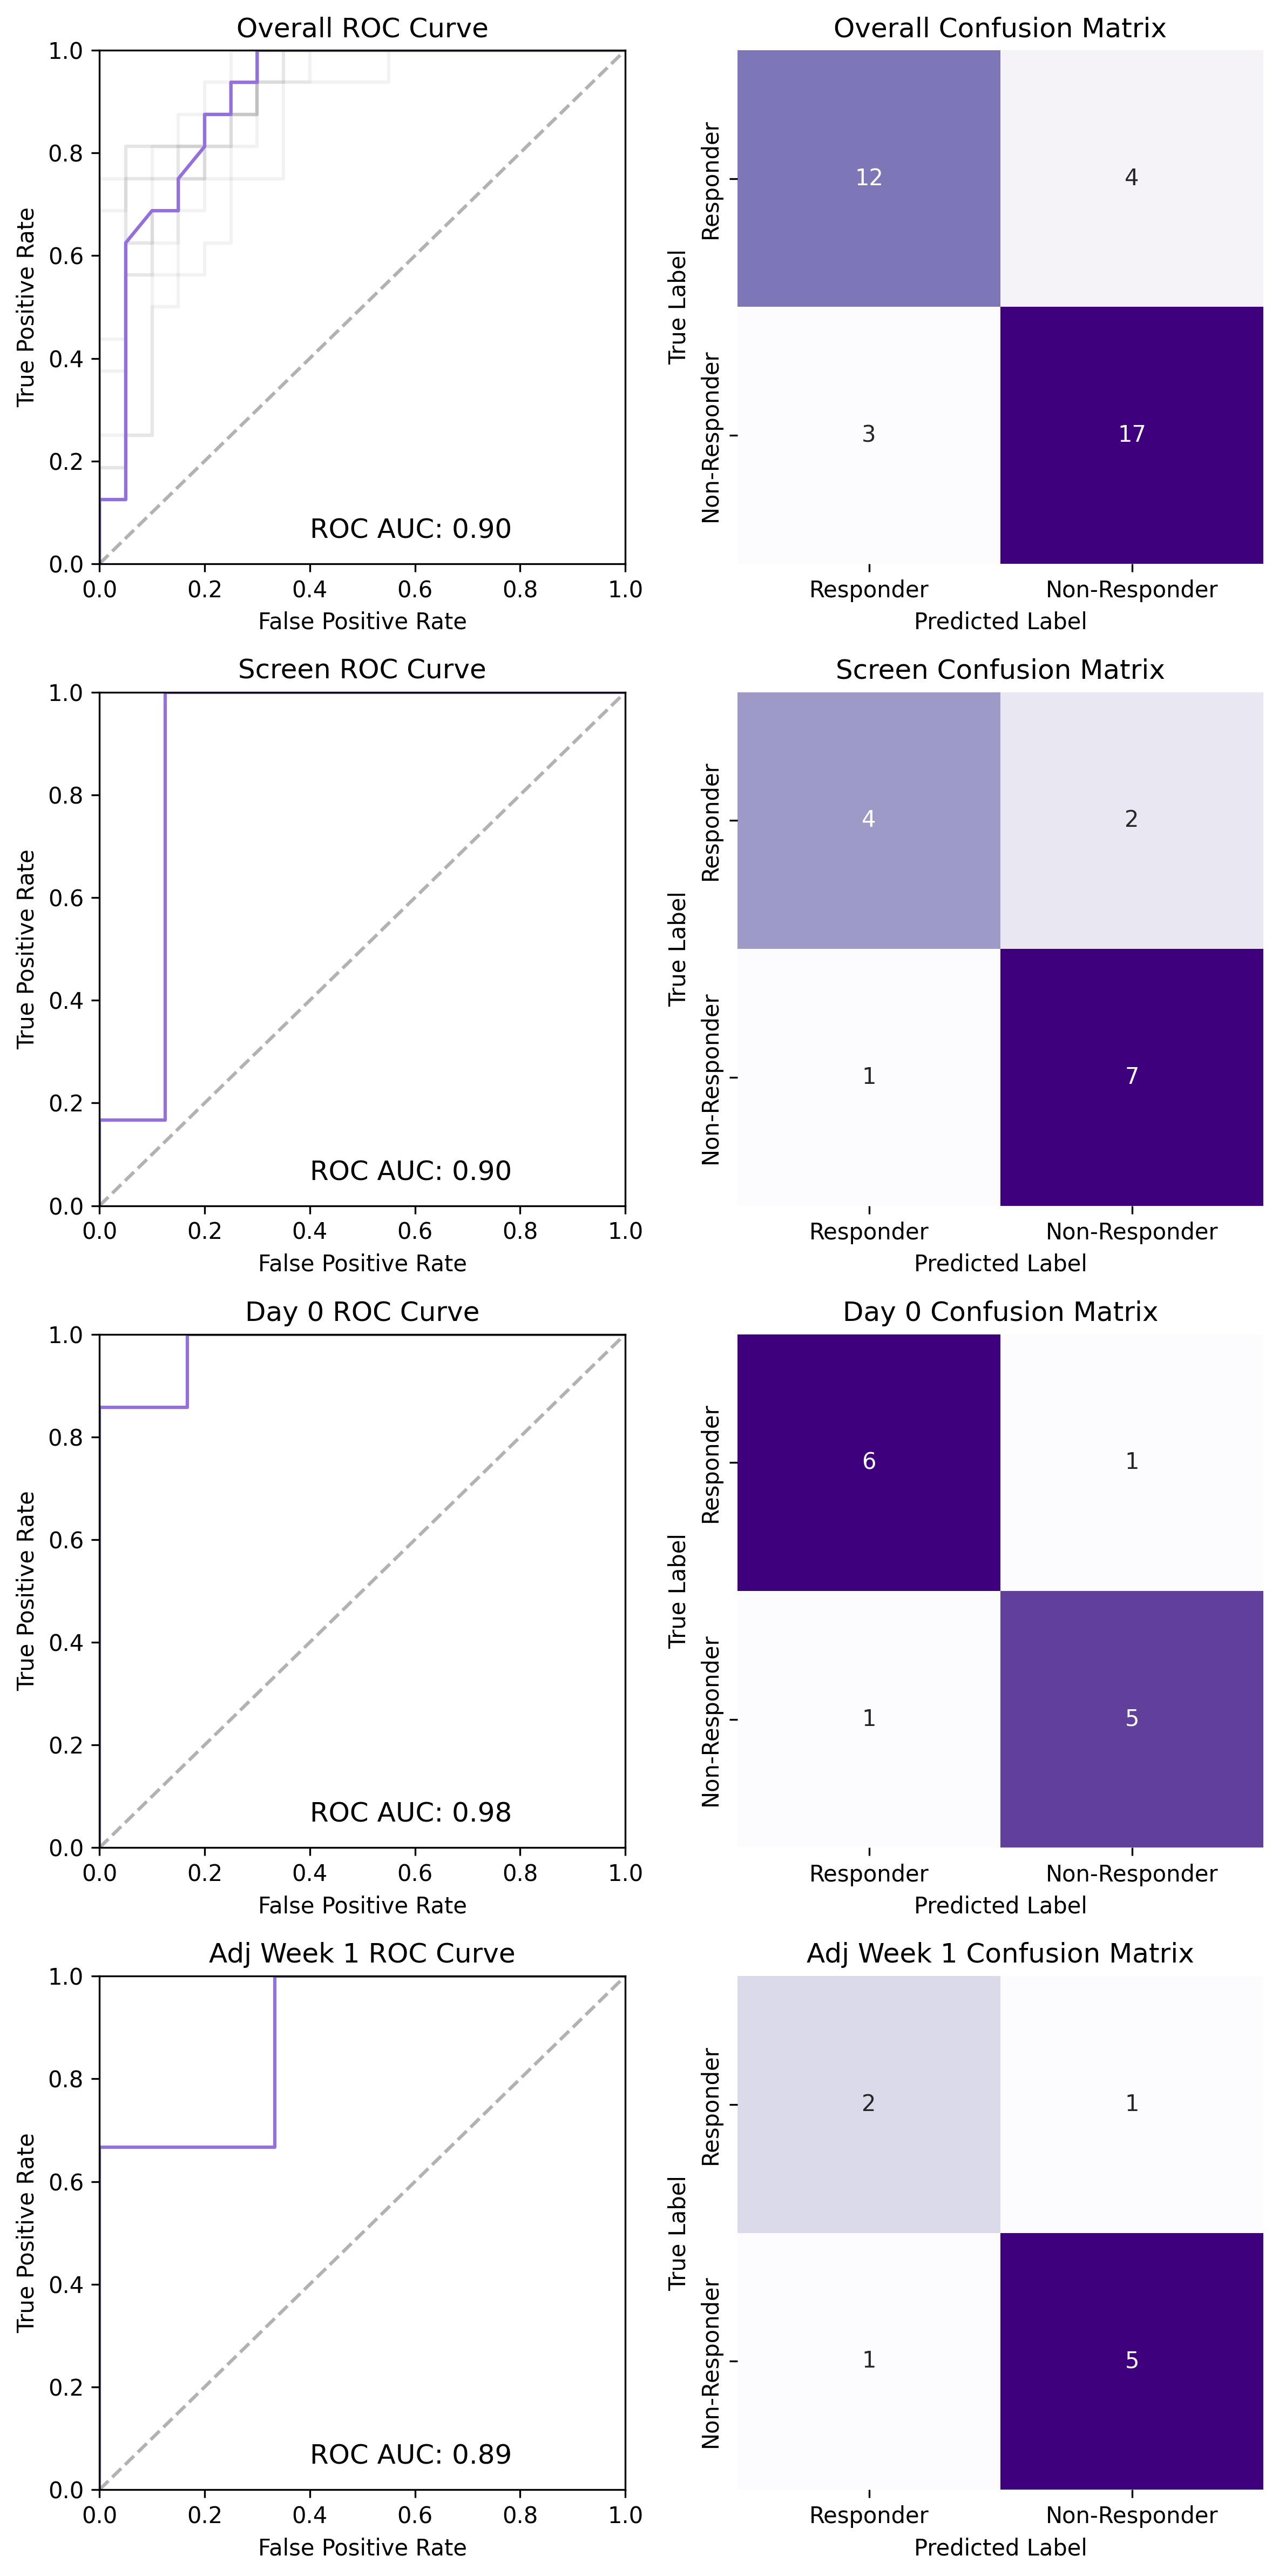

Best Overall Model: RandomForestClassifier(n_estimators=200)
Top Features: ['chr11:104500000-105000000', 'chr16:10000000-10500000', 'chr16:77000000-77500000', 'chr1:2000000-2500000', 'chr2:109000000-109500000', 'chr2:166500000-167000000', 'chr4:135000000-135500000', 'chr4:178000000-178500000', 'chr4:57500000-58000000', 'chr5:126000000-126500000', 'chr6:133500000-134000000', 'chr6:46000000-46500000', 'chr8:77500000-78000000', 'chr8:79500000-80000000', 'chr8:87500000-88000000', 'chr9:101500000-102000000', 'chr12:48000000-48500000', 'chr2:50500000-51000000', 'chr5:136000000-136500000', 'chr5:51500000-52000000', 'chr6:36000000-36500000', 'chr11:103500000-104000000', 'chr2:172500000-173000000', 'chr3:5000000-5500000', 'chr3:50000000-50500000', 'chr6:39500000-40000000', 'chr6:44500000-45000000', 'chr6:46500000-47000000', 'chr5:32500000-33000000', 'chr18:9000000-9500000', 'chr1:55000000-55500000', 'chr4:173000000-173500000', 'chr13:100500000-101000000', 'chr16:19500000-20000000', 'chr5:142000

In [3]:
delfi_rfc_results, delfi_rfc_model, delfi_rfc_top_features, delfi_rfc_preds_dictionary, delfi_data = delfi.train_test_model(models[0], param_grids['RandomForestClassifier'], delfi_train, delfi_test, cv_split=10, k=50)

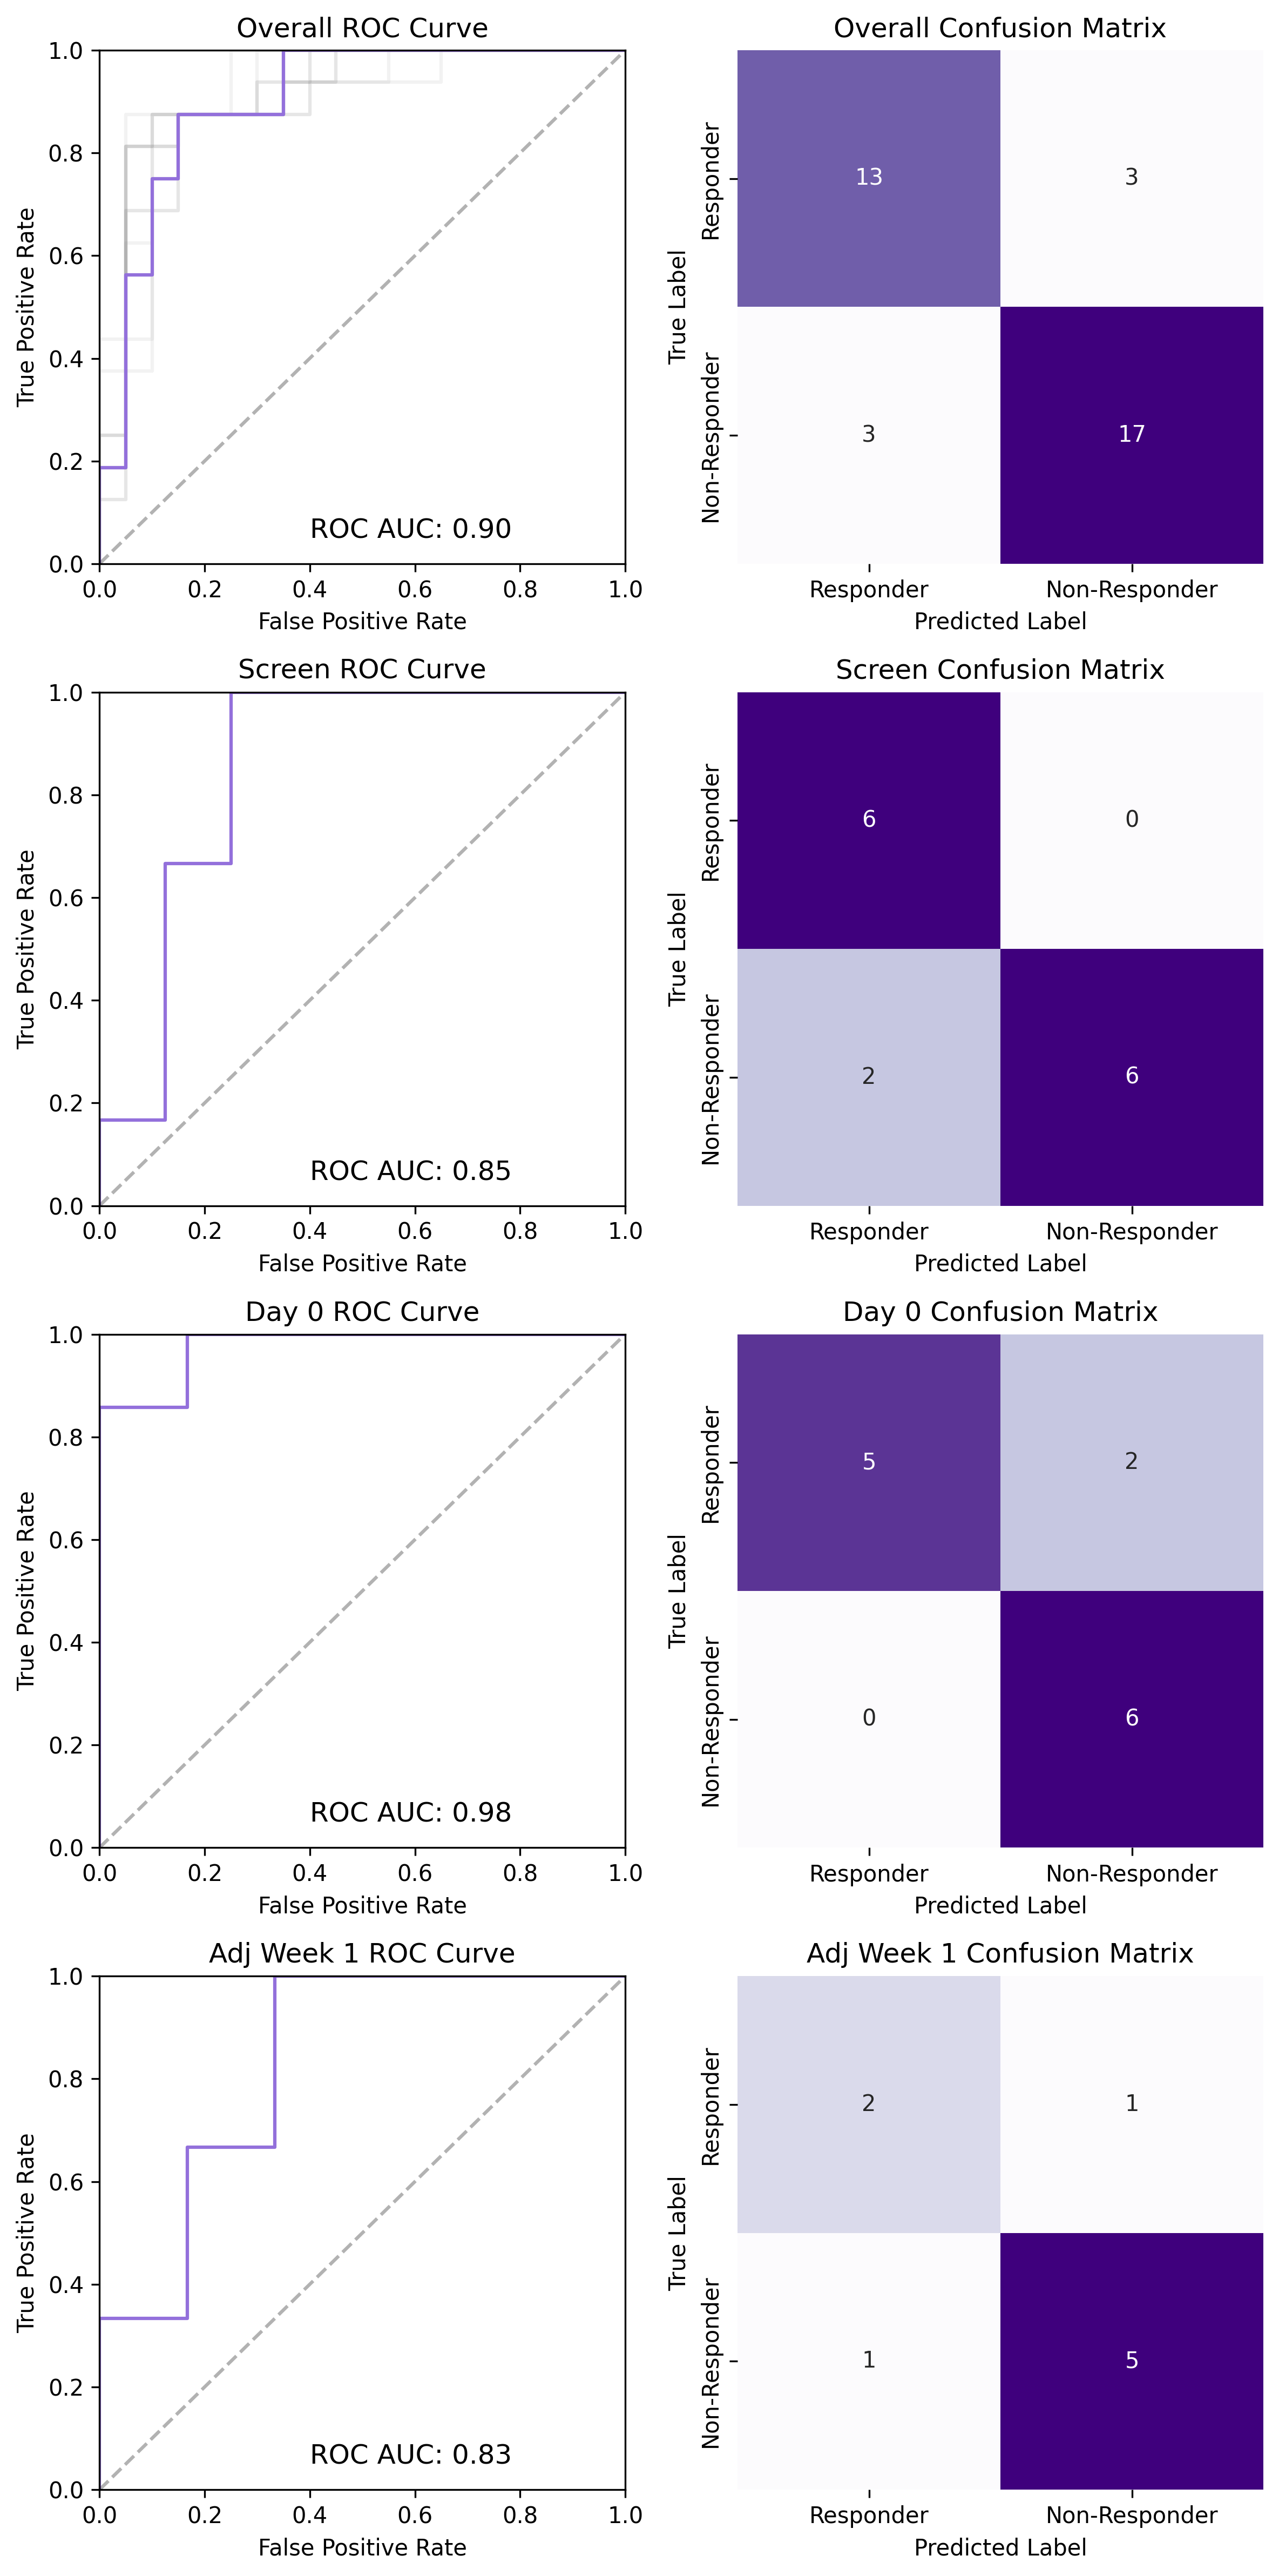

Best Overall Model: RandomForestClassifier()
Top Features: ['chr14:95000000-95500000', 'chr15:89500000-90000000', 'chr18:31500000-32000000', 'chr1:199500000-200000000', 'chr1:22000000-22500000', 'chr21:34500000-35000000', 'chr2:154500000-155000000', 'chr2:188000000-188500000', 'chr2:20500000-21000000', 'chr3:11000000-11500000', 'chr3:133500000-134000000', 'chr3:51500000-52000000', 'chr5:25500000-26000000', 'chr5:91500000-92000000', 'chr6:104000000-104500000', 'chr6:76500000-77000000', 'chr7:108500000-109000000', 'chr9:11000000-11500000', 'chr9:115000000-115500000', 'chr4:85500000-86000000', 'chr7:151500000-152000000', 'chr8:104000000-104500000', 'chr8:121500000-122000000', 'chr9:73000000-73500000', 'chr12:7000000-7500000', 'chr2:198000000-198500000', 'chr2:56000000-56500000', 'chr3:128500000-129000000', 'chr6:50000000-50500000', 'chr20:33000000-33500000', 'chr12:109500000-110000000', 'chr7:106000000-106500000', 'chr7:115500000-116000000', 'chr8:35500000-36000000', 'chr7:91000000-915000

In [4]:
mds_rfc_results, mds_rfc_model, mds_rfc_top_features, mds_rfc_preds_dictionary, mds_data = mds.train_test_model(models[0], param_grids['RandomForestClassifier'], mds_train, mds_test, cv_split=10, k=50)

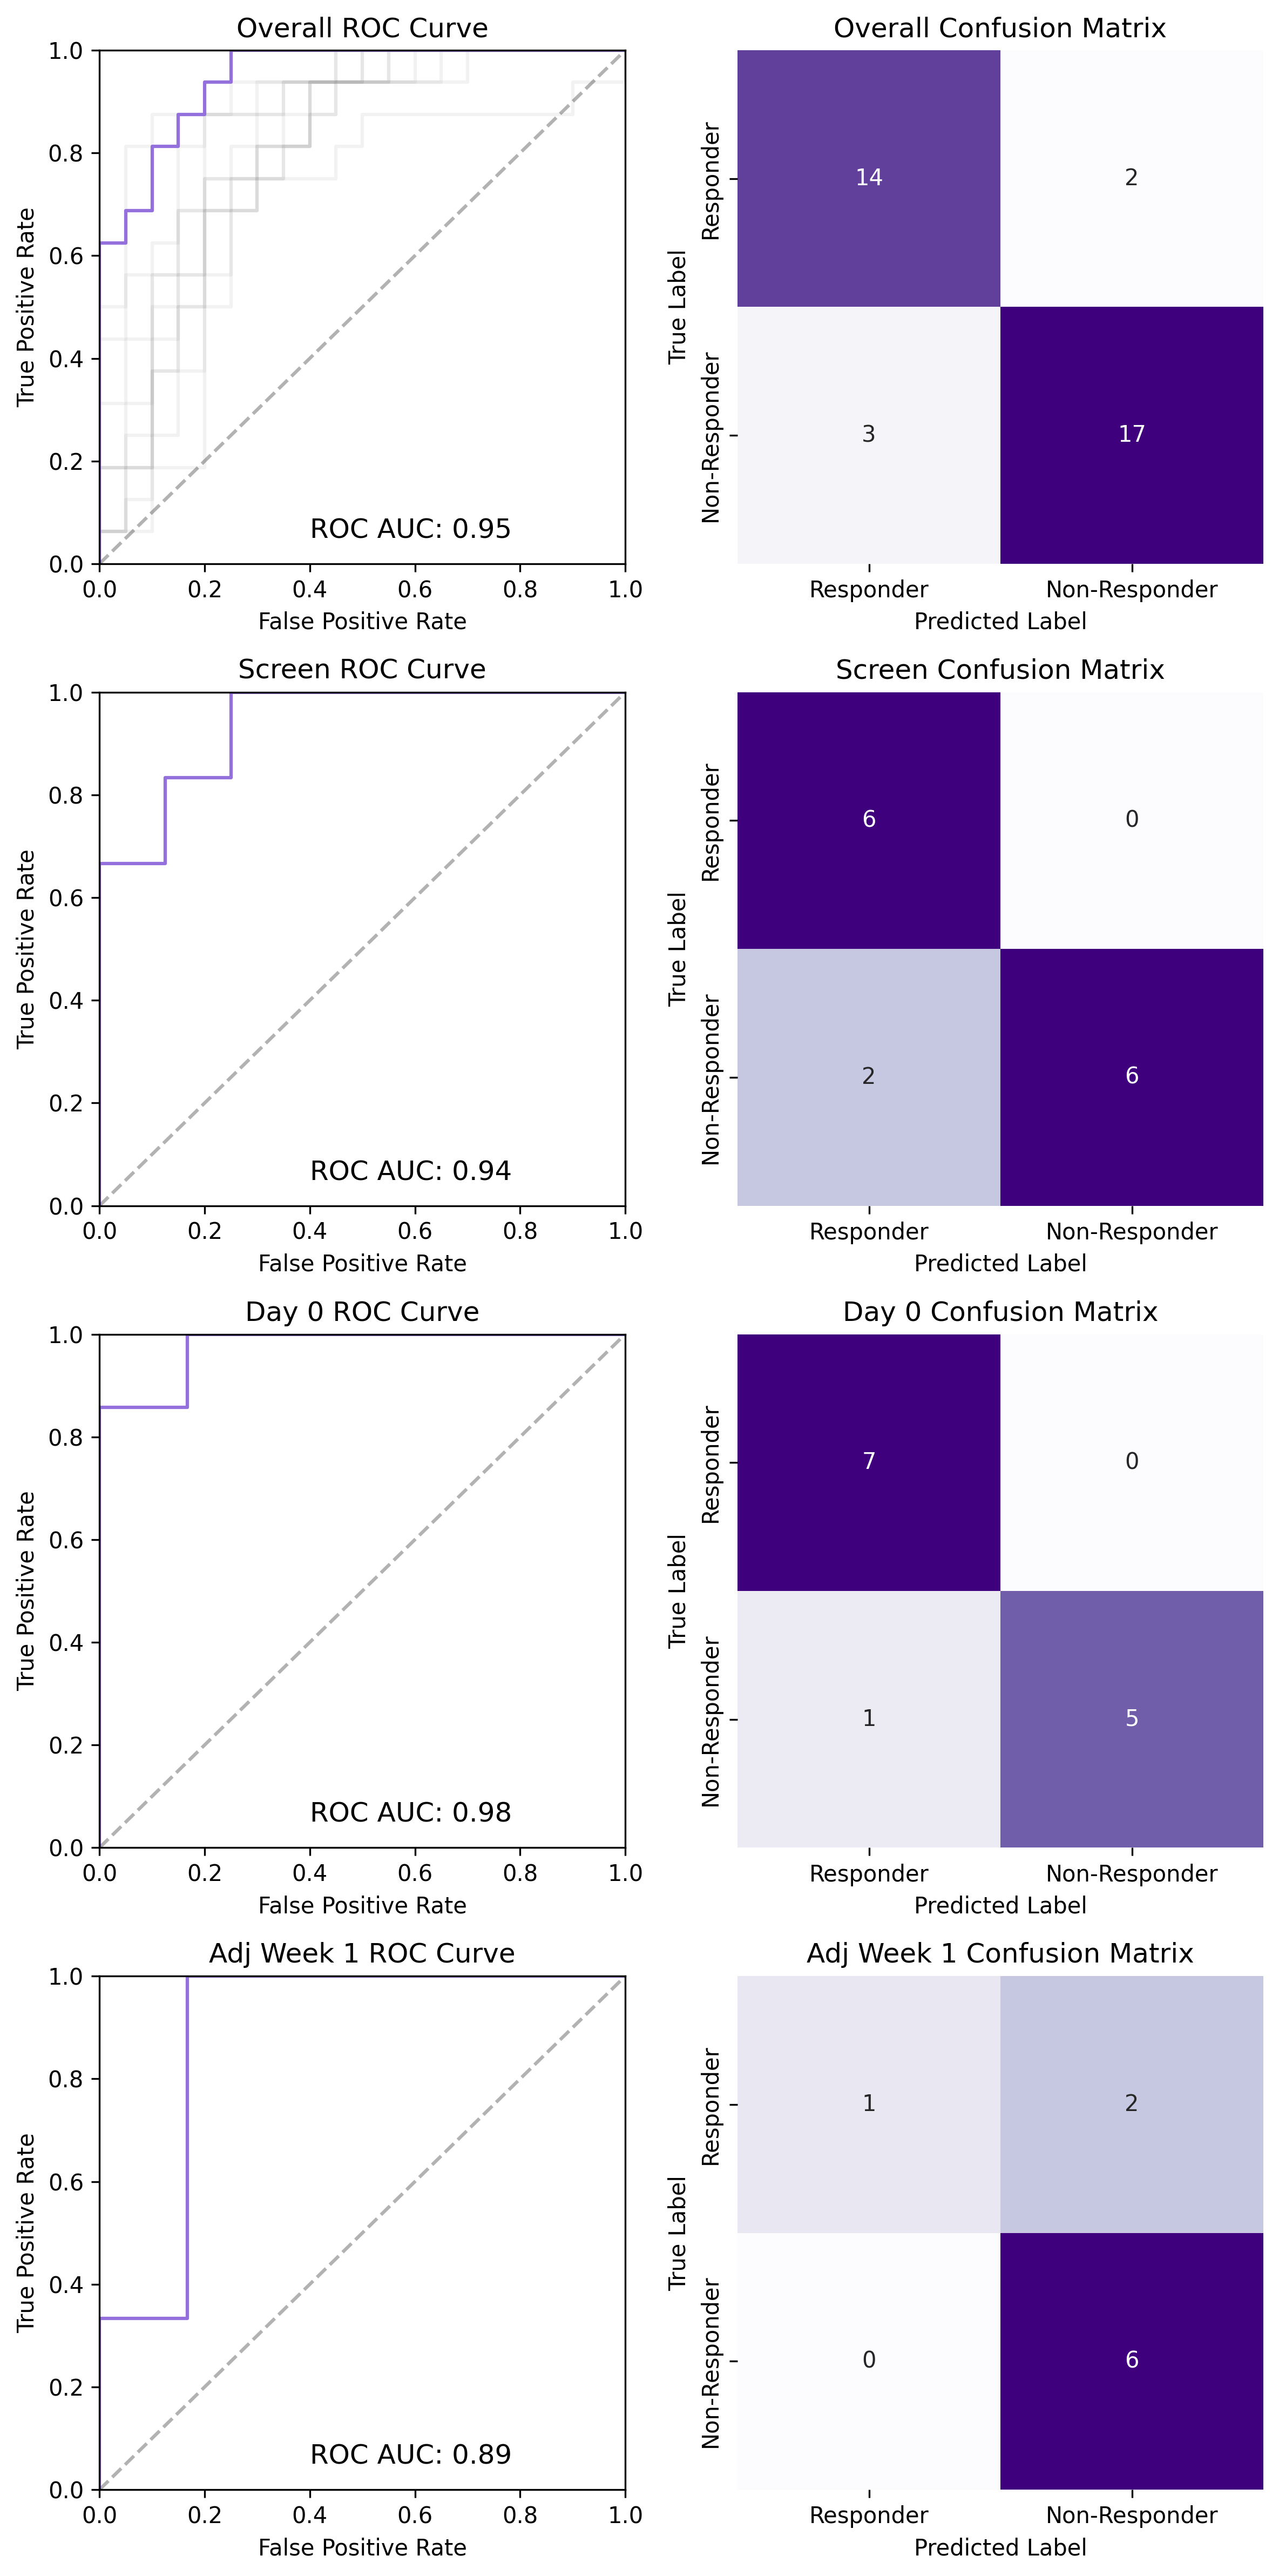

Best Overall Model: GradientBoostingClassifier(min_samples_split=5, n_estimators=50)
Top Features: ['chr10:56000000-56500000', 'chr12:48000000-48500000', 'chr12:84500000-85000000', 'chr16:1000000-1500000', 'chr17:80500000-81000000', 'chr1:190000000-190500000', 'chr1:22000000-22500000', 'chr1:222000000-222500000', 'chr2:140000000-140500000', 'chr3:85500000-86000000', 'chr4:72000000-72500000', 'chr5:107500000-108000000', 'chr5:112000000-112500000', 'chr7:79000000-79500000', 'chr10:132000000-132500000', 'chr12:132000000-132500000', 'chr20:32500000-33000000', 'chr11:102500000-103000000', 'chr15:68000000-68500000', 'chr19:27500000-28000000', 'chr14:76500000-77000000', 'chr18:71000000-71500000', 'chr14:32000000-32500000', 'chr19:33000000-33500000', 'chr1:2000000-2500000', 'chr1:7500000-8000000', 'chr2:164500000-165000000', 'chr2:225000000-225500000', 'chr4:3000000-3500000', 'chr5:142000000-142500000', 'chr6:131500000-132000000', 'chr8:71500000-72000000', 'chr9:134000000-134500000', 'chr11:24

In [5]:
fraglen_gbc_results, fraglen_gbc_model, fraglen_gbc_top_features, fraglen_gbc_preds_dictionary, fraglen_data = fraglen.train_test_model(models[1], param_grids['GradientBoostingClassifier'], fraglen_train, fraglen_test, cv_split=10, k=50)

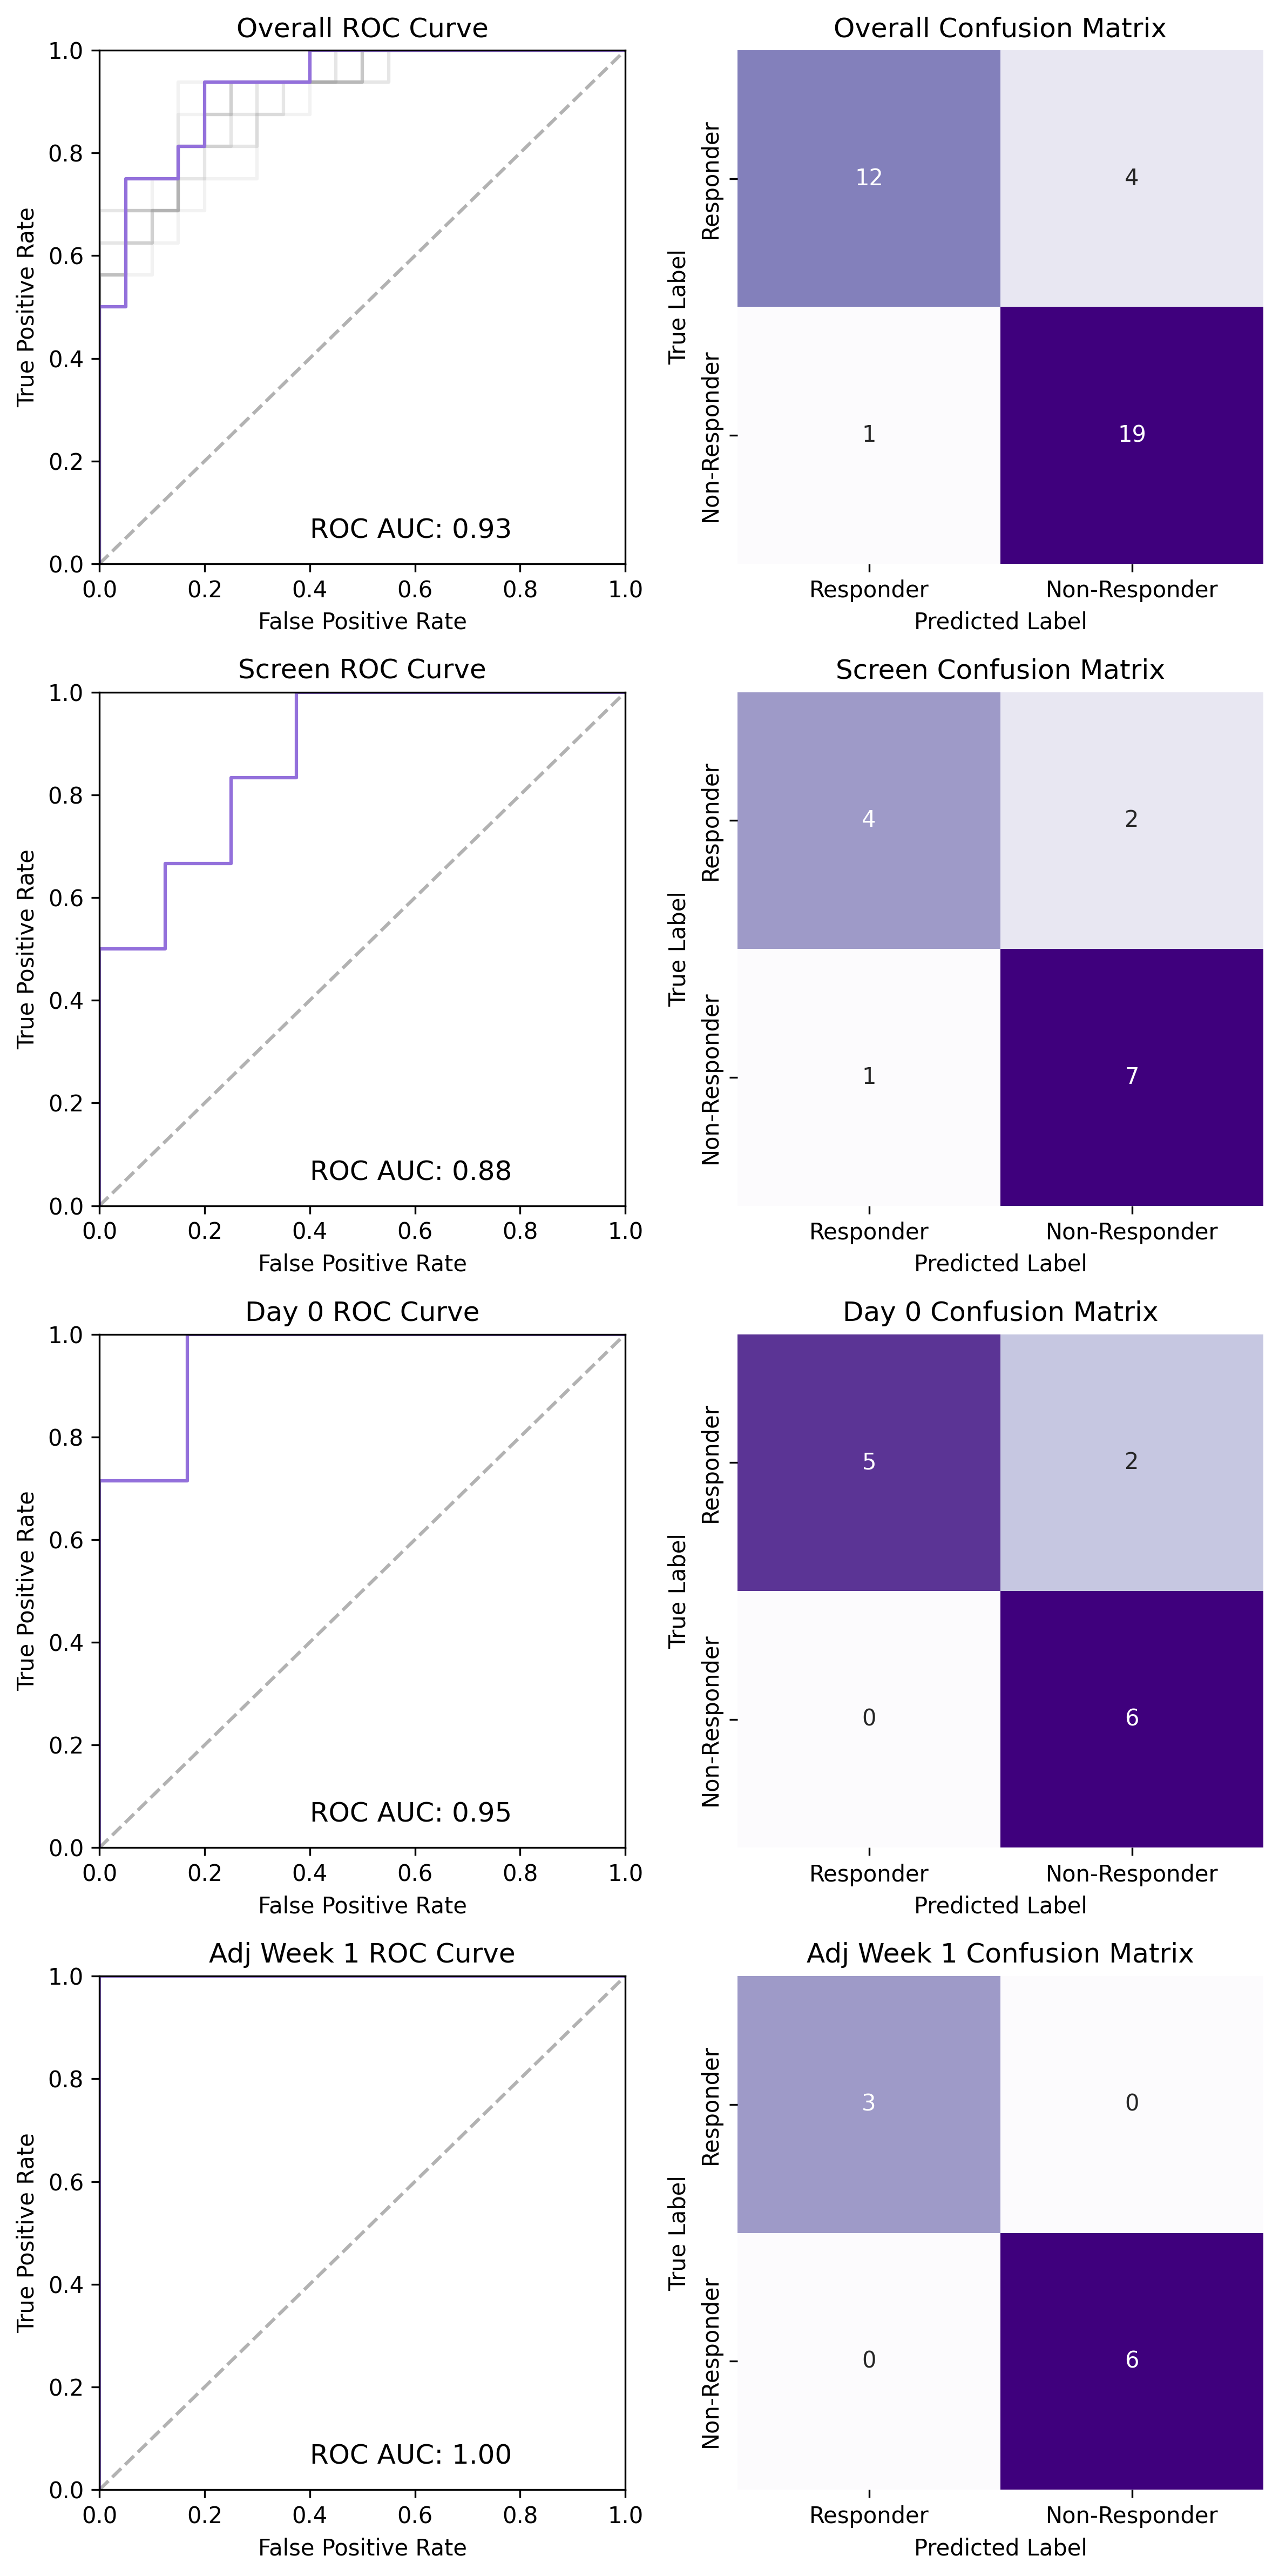

Best Overall Model: RandomForestClassifier(max_depth=5, max_features='log2', min_samples_leaf=4,
                       n_estimators=50)
Top Features: ['chr10:104000001-104500000', 'chr10:2000001-2500000', 'chr11:103000001-103500000', 'chr14:62500001-63000000', 'chr16:52000001-52500000', 'chr1:27000001-27500000', 'chr20:42500001-43000000', 'chr2:3000001-3500000', 'chr2:6000001-6500000', 'chr2:80500001-81000000', 'chr5:136500001-137000000', 'chr5:5000001-5500000', 'chr6:168500001-169000000', 'chr6:76500001-77000000', 'chr7:132000001-132500000', 'chr7:68500001-69000000', 'chr7:71000001-71500000', 'chr9:117000001-117500000', 'chr11:41500001-42000000', 'chr16:7500001-8000000', 'chr18:28000001-28500000', 'chr20:19000001-19500000', 'chr4:174000001-174500000', 'chr5:167000001-167500000', 'chr2:14000001-14500000', 'chr7:53500001-54000000', 'chr2:209000001-209500000', 'chr2:52000001-52500000', 'chr3:64500001-65000000', 'chr6:13500001-14000000', 'chr12:128000001-128500000', 'chr2:80000001-805000

In [6]:
cna_rfc_results, cna_rfc_model, cna_rfc_top_features, cna_rfc_preds_dictionary, cna_data = cna.train_test_model(models[0], param_grids['RandomForestClassifier'], cna_train, cna_test, cv_split=10, k=50)

/tmp/ipykernel_54896/138782906.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='Purples_r')


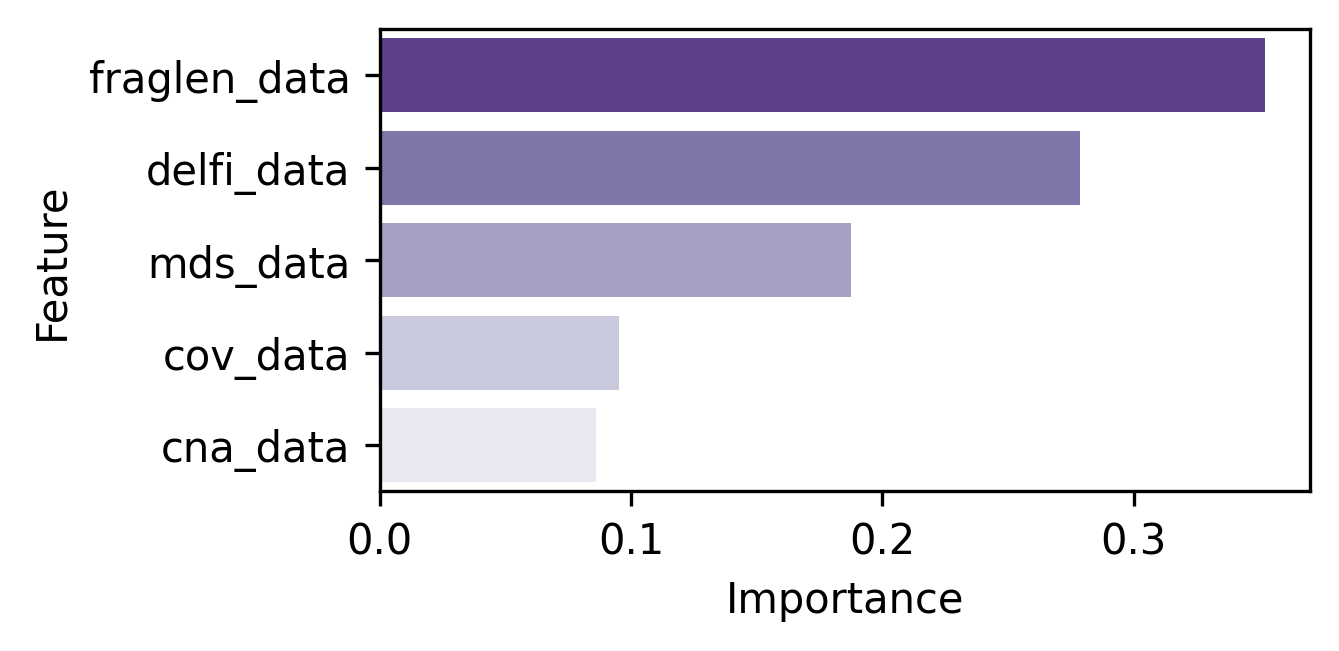

               precision    recall  f1-score   support

Non-Responder       1.00      0.95      0.97        20
    Responder       0.93      1.00      0.97        14

     accuracy                           0.97        34
    macro avg       0.97      0.97      0.97        34
 weighted avg       0.97      0.97      0.97        34



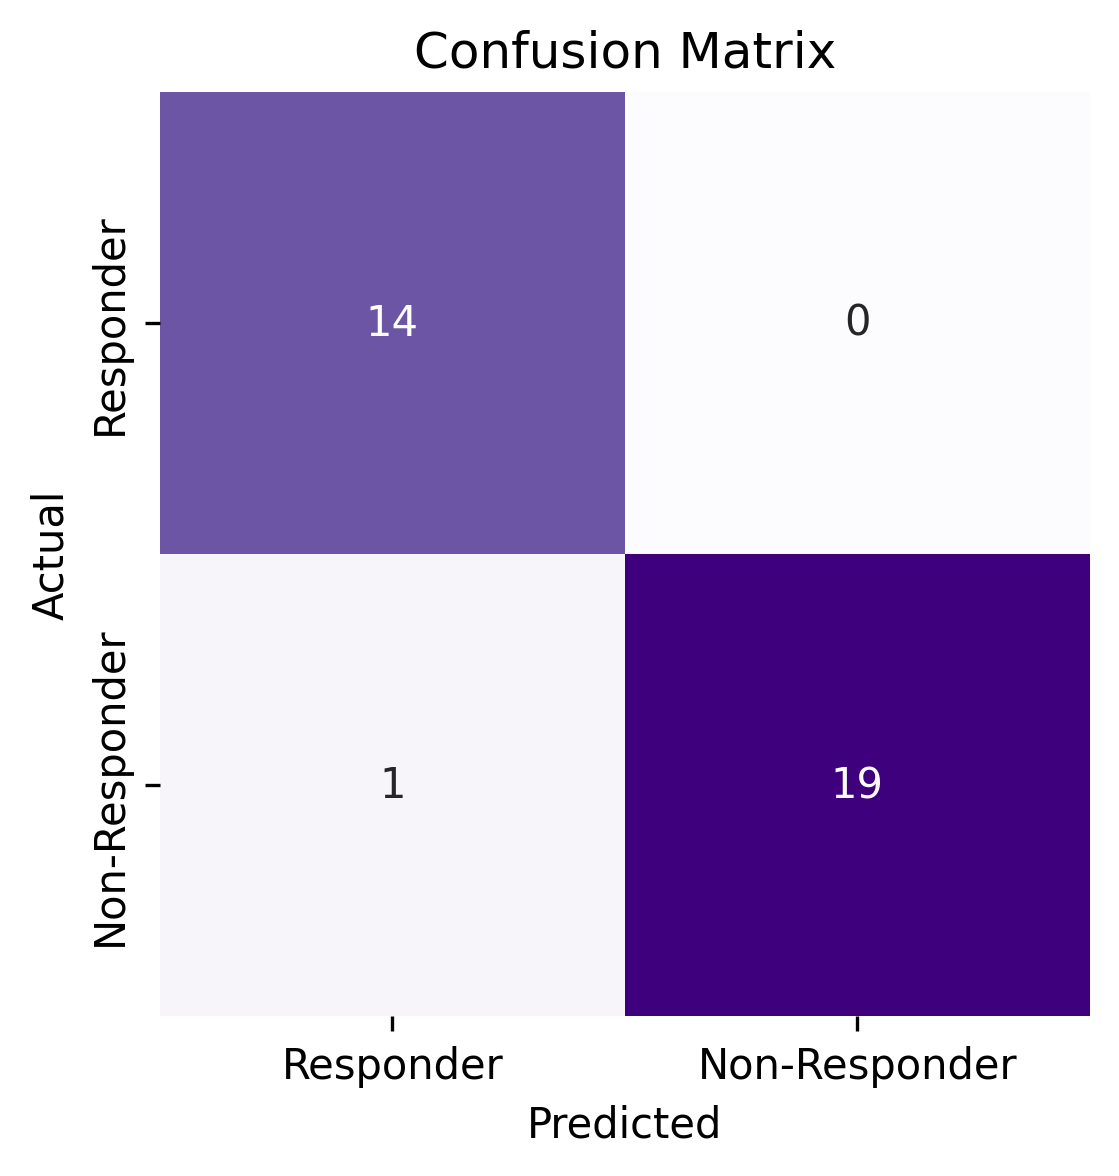

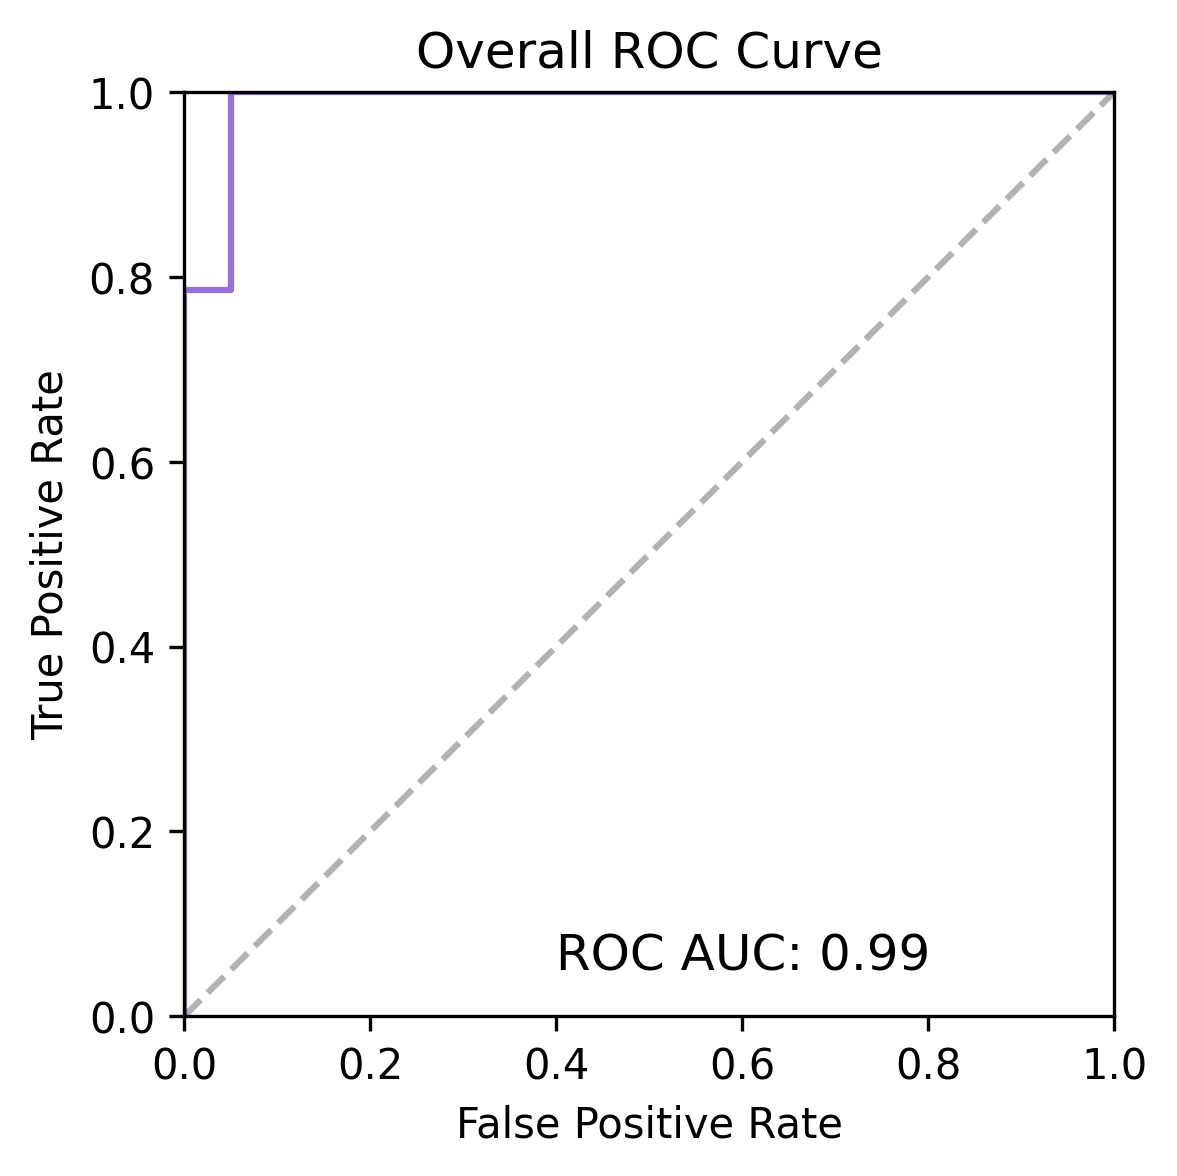

In [14]:
# Create the combined DataFrame with the necessary columns
combined_data = pd.DataFrame({
    'cov_data': cov_data['Predicted Treatment Probabilities'],
    'delfi_data': delfi_data['Predicted Treatment Probabilities'],
    'mds_data': mds_data['Predicted Treatment Probabilities'],
    'fraglen_data': fraglen_data['Predicted Treatment Probabilities'],
    'cna_data': cna_data['Predicted Treatment Probabilities'],
    'Treatment Response': cna_data['Treatment Response']
})

# Combine train and test IDs
train_ids = list(cov.institute1_ids) + list(cov.institute2_ids) + list(cov.institute3_ids) + list(cov.institute4_ids)
test_ids = list(cov.institute5_ids) + list(cov.institute6_ids)

# Splitting the data based on train and test IDs
meta_train = combined_data[combined_data.index.isin(train_ids)]
meta_test = combined_data[combined_data.index.isin(test_ids)]

# Prepare X (features) and y (target) for training
X = combined_data.drop(columns=['Treatment Response'])
y = combined_data['Treatment Response']

# Splitting the data for model training (80% train, 20% test split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize RandomForestClassifier and train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature importance plot
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(4, 2), dpi=300)
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='Purples_r')
plt.show()

# Predictions on the test data
predictions = rf.predict(X_test)
predictions_df = pd.DataFrame(predictions, index=X_test.index, columns=['Predicted Treatment Response'])

# Add the predicted values to the combined_data DataFrame
combined_data['Predicted Treatment Response'] = rf.predict(X)

# Calculate probabilities for the positive class (Responder)
probs = rf.predict_proba(X_test)[:, 1]  # Probability for positive class (Responder)

# Classification report and confusion matrix
print(classification_report(y_test, predictions))

cm = confusion_matrix(y_test, predictions, labels=['Responder', 'Non-Responder'])
plt.figure(figsize=(4, 4), dpi=300)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False, xticklabels=['Responder', 'Non-Responder'],
            yticklabels=['Responder', 'Non-Responder'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC curve
fpr, tpr, thresholds = roc_curve([1 if label == 'Responder' else 0 for label in y_test], probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4, 4), dpi=300)
plt.plot(fpr, tpr, color='mediumpurple')
plt.text(0.4, 0.05, f'ROC AUC: {roc_auc:.2f}', fontsize=12, color='black')
plt.plot([0, 1], [0, 1], color='black', alpha=0.3, linestyle='--')
plt.title(f'Overall ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()


In [15]:
pd.set_option('display.max_rows', None)

In [16]:
test_data = combined_data[combined_data.index.isin(test_ids)]
screen_data = cov.get_subset(cov.screen_ids, df=combined_data)
test_screen_data = cov.get_subset(cov.screen_ids, df=test_data)
day0_data = cov.get_subset(cov.day0_ids, df=combined_data)
test_day0_data = cov.get_subset(cov.day0_ids, df=test_data)
adjwk1_data = cov.get_subset(cov.adjwk1_ids, df=combined_data)
test_adjwk1_data = cov.get_subset(cov.adjwk1_ids, df=test_data)

In [47]:
train_data = combined_data[combined_data.index.isin(train_ids)]
test_data = combined_data[combined_data.index.isin(test_ids)]

In [18]:
test_screen_data

,cov_data,delfi_data,mds_data,fraglen_data,cna_data,Treatment Response,Predicted Treatment Response
Pilot2_49,0.731476,0.550,0.69,0.601161,0.480104,Responder,Responder
Pilot2_51,0.229762,0.465,0.17,0.539818,0.112256,Non-Responder,Non-Responder
Pilot2_54,0.547560,0.690,0.37,0.793534,0.725041,Non-Responder,Responder
Pilot2_57,0.231250,0.490,0.64,0.507287,0.189962,Responder,Responder
Pilot2_60,0.549929,0.825,0.71,0.886320,0.856205,Responder,Responder
Pilot2_63,0.502417,0.335,0.21,0.228300,0.030351,Non-Responder,Non-Responder
Pilot2_65,0.201417,0.400,0.30,0.098971,0.485507,Non-Responder,Non-Responder
Pilot2_71,0.731111,0.305,0.85,0.044481,0.128747,Non-Responder,Non-Responder
Pilot2_75,0.292762,0.350,0.11,0.013544,0.407501,Non-Responder,Non-Responder
Pilot2_78,0.841476,0.590,0.80,0.991431,0.943254,Responder,Responder


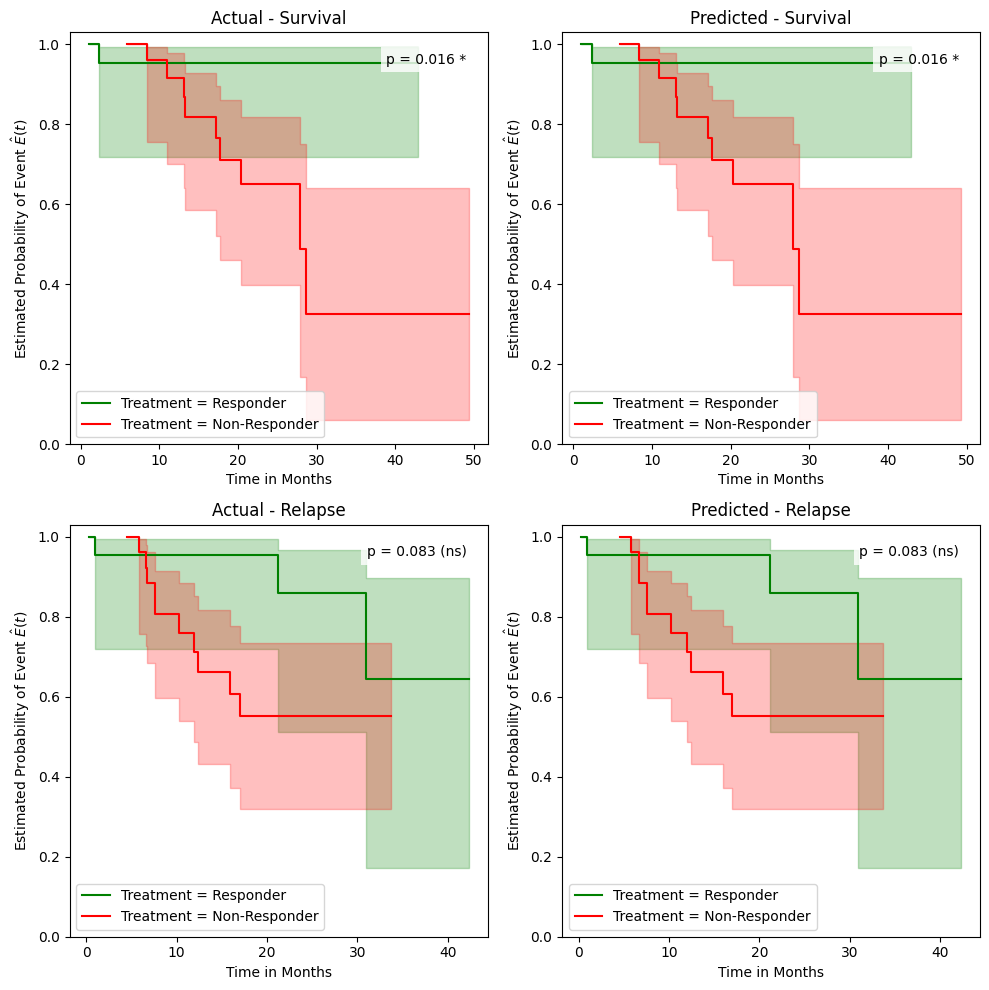

In [22]:
cov.survival_curve(day0_data['Predicted Treatment Response'].to_dict())